# Model Architecture

This ia a tiny CLIP-style Vision-Language Model(VLM).

It has two seperate encoders - one for images and one for text.

Both encoders map their inputs into a common embedding space of dimention 64 (or other dimention we choose).

The goal is to make matching image-text pairs lie close together in the space

These embeddings are then compared using **Contrastive Loss**, ensuring that the matching image-text pairs are closer in the common embedding space.


                          Contrastive Loss
                          /              \
                CNN-based Image Encoder    Text Encoder
                       |                        |
                   Image:                     Text:
            "brown circle bottom right"  "brown circle bottom right"


In [ ]:
import numpy as np
import math, random
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [ ]:
# Variables

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEAD = 4
BATCH_SIZE = 12
EPOCHS = 20
LR = 3e-4
TEMPERATURE = 0.05

In [ ]:
# Synthetic dataset properties

colors = [
    'red', 'green', 'blue', 'yellow', 'purple',
    'orange', 'pink', 'brown', 'gray'
]

shapes = [
    'square', 'circle', 'triangle'
]

positions = [
    'left', 'center', 'right',
    'top', 'bottom',
    'top-left', 'top-right',
    'bottom-left', 'bottom-right'
]

In [ ]:
# Drawing Image shape

def draw_sample(color, shape, position, img_size=IMG_SIZE):
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    margin = 6
    h = w = img_size - 2 * margin

    # Calculate x coordinates
    if 'left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    else:  # center
        x0 = margin + w // 4
        x1 = margin + 3 * w // 4

    # Calculate y coordinates
    if 'top' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'bottom' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    else:  # center
        y0 = margin + h // 4
        y1 = margin + 3 * h // 4

    # Draw shape
    if shape == 'square':
        draw.rectangle([x0, y0, x1, y1], fill=color, outline='black')
    elif shape == 'circle':
        draw.ellipse([x0, y0, x1, y1], fill=color, outline='black')
    else:  # triangle
        draw.polygon([((x0 + x1) // 2, y0), (x0, y1), (x1, y1)], fill=color, outline='black')

    return img

In [ ]:
# Class for building our dataset

class ShapesDataset():
  def __init__(self):
    self.images = []
    self.captions = []

    for c in colors:
      for s in shapes:
        for p in positions:
          img = draw_sample(c, s, p)
          cap = f"{c} {s} {p}"
          arr = np.array(img, dtype=np.uint8, copy=True)
          self.images.append(torch.from_numpy(arr).permute(2,0,1).float()/255.0)
          # self.images.append(torch.from_numpy(np.asarray(img), dtype=np.uint8, copy=True).permute(2,0,1).float()/255.0)
          self.captions.append(cap)

    self.vocab, self.word2idx = self.build_vocab(self.captions)

  def build_vocab(self, texts):
    words = sorted({w for t in texts for w in t.split()})
    vocab = ['[CLS]'] + words
    w2i = {w:i for i,w in enumerate(vocab)}
    return vocab, w2i

  def encode_text(self, text):
    toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
    return torch.tensor(toks, dtype=torch.long)

  def __len__(self): return len(self.images)

  def __getitem__(self, i):
    return self.images[i],  self.encode_text(self.captions[i]), self.captions[i]


In [ ]:
# Creating the dataset
full_ds = ShapesDataset()
VOCAB_SIZE =  len(full_ds.vocab)

print(VOCAB_SIZE)

22


In [ ]:
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size

train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

In [ ]:
# Dataloader
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = False)

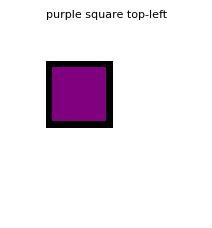

In [ ]:
imgs, encoded_caps, captions = next(iter(train_loader))
idx = random.randint(0, len(imgs) - 1)
img = (imgs[idx].permute(1,2,0).numpy() * 255).astype(np.uint8)
# print(encoded_caps)
plt.figure(figsize=(2.5, 2.5))
plt.imshow(img)
plt.title(captions[idx], fontsize=8)
plt.axis('off')
plt.show()

# Image Encoder

*  A small CNN (4 convolution layers) progressively downsamples the input image.
*  After the convolution blocks, a global average pooling layer reduces spiral features.
*  A liner projection maps to the embedding dimension.
*  Finally, a LayerNorm + L2 normalization ensures embeddings are unit vectors (important for cosine similarity).

Input Image -> (32 * 32 * 3) -> (16 * 16 * 32) -> (8 * 8 * 64) -> (4 * 4 * 128) -> (2 * 2 * 256) -> {Global Average Pooling}(1 * 1 * 256) -> (1 * 1 * 64) -> LayerNorm + Normalize -> (1 * 1 *  64)

No of parameters

3 * 3 * 3 * 32 + 32  = 896

32 * 3 * 3 * 64 + 64 = 18496

64 * 3  * 3 * 128 + 128 = 73856

128 * 3 * 3 * 256 + 256 = 295168

GAP = 0

256 * 64 + 64 = 16448

2 * 64 = 128

Total no of parameters = 404992



In [ ]:
# Image encoder
class ImageEncoder(nn.Module):
  def __init__(self, embed_dim = EMBED_DIM) -> None:
     super().__init__()
     self.convolutions = nn.Sequential(
         nn.Conv2d(3,32,3,2,1),
         nn.ReLU(),
         nn.Conv2d(32,64,3,2,1),
         nn.ReLU(),
         nn.Conv2d(64,128,3,2,1),
         nn.ReLU(),
         nn.Conv2d(128,256,3,2,1),
         nn.ReLU(),
         )
     self.projection = nn.Linear(256,embed_dim)
     self.layernorm1 = nn.LayerNorm(embed_dim)

  def forward(self,x):
    x = self.convolutions(x)
    x = x.mean(dim = [2,3])
    x = self.projection(x)
    x = F.normalize(self.layernorm1(x), dim=-1)
    return x

# Text Encoder



*   Each caption has tocken like [CLS] red triangle left.
*   A tocken embedding layers convert each word to a 64-d vector.
*   A potional embedding layer add position info (like transformer).

*   MHA after this.
*   Followed by a Linear layer + LayerNorm + L2 normalization.





nn.Embedding(vocab_size, embed_dim) create a lookuop table


*   Each token ID (like 5, 101, 7, etc )is mapped to a vector of size embed_dim (say 64).
*   So self.tok(toks) does not calculate tokens - it converts tocken IDs into embedding vectors.

pos_ids = torcharange(L, device=toks.device).unsqueedze(N,L)
for example
l=4, N=2

tensor([
  [0,1,2,3],
  [0,1,2,3]
])

torch.arange(L) by default, this is created on CPU.
x = self.tok(toks) + self.pos(pos_ids)
They both must be on the same device. Otherwise , Pytorch throws an error.
.unsqueeze(0) , this add new dimention and the shape become (1,4)

No of paramater (Text encoder)

Vocab = 22, Token Dim = 64, Context Window = 4

Vocab 22 * 64 = 1408,
pos 4 * 64 = 256

MHA:-
4 head , Wq,Wk,Wv Per-Head , Dim per head  = 64/4 = 16

Wq -> Wk -> Wv -> (64 * 16) + 16

= (64 * 16 + 16) * 3 * 4 = 12480

Output Projection = 64 * 64 + 64 = 4160

Prozection 64 * 64 + 64 = 4160

Norm 64 * 2 = 128

Total No of Parameters = 22592

In [ ]:
# Text Encoder
class TextEncoder(nn.Module):
  def __init__(self,embed_dim = EMBED_DIM, num_head = ATTENTION_HEAD, vocab_size = VOCAB_SIZE,
                      context_window = 4) -> None:

    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, embed_dim)
    self.position_embedding = nn.Embedding(context_window, embed_dim)
    self.mha = nn.MultiheadAttention(embed_dim, num_head, batch_first=True)
    self.projection = nn.Linear(embed_dim, embed_dim)
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, toks):
    N, L = toks.shape
    position_emb_ids = torch.arange(L, device = toks.device).unsqueeze(0).expand(N,L)
    position_embedding_vectors = self.position_embedding(position_emb_ids)
    token_embedding_ids = toks
    token_embedding_vectors = self.token_embedding(token_embedding_ids)
    final_embedding = token_embedding_vectors + position_embedding_vectors
    context_vectors = self.mha(final_embedding,
                               final_embedding,
                               final_embedding)[0]
    final_token = context_vectors[:, 0]
    projection = self.projection(final_token)
    output = F.normalize(self.norm(projection), dim=-1)
    return output

In [ ]:
# Clip loss

def clip_loss(img_emb, txt_emb, temperature = TEMPERATURE):
  logits = img_emb @ txt_emb.t() / temperature      # N * N
  targets = torch.arange(img_emb.size(0), device = img_emb.device)
  loss_i = F.cross_entropy(logits, targets)
  loss_t = F.cross_entropy(logits.t(), targets)
  return ((loss_i + loss_t)/2.0)

In [ ]:
# Model, Data, Optimizer

img_enc = ImageEncoder().to(device)
text_enc = TextEncoder().to(device)
params = list(img_enc.parameters()) + list(text_enc.parameters())
optimizer = torch.optim.AdamW(params,lr = LR)

In [ ]:
# VOCAB_SIZE = len(full_ds.vocab)
# img_enc = ImageEncoder().to(device)
# text_enc = TextEncoder(VOCAB_SIZE).to(device)
# params = list(img_enc.parameters()) + list(text_enc.parameters())
# optimizer = torch.optim.AdamW(params,lr = LR)

In [ ]:
# Display embeddings before training

def show_image(t, title=None):
  img_arr = (t.permute(1,2,0).numpy()*255).astype(np.uint8)
  plt.figure(figsize=(2.2,2.2))
  plt.axis("off")
  if title: plt.title(title, fontsize=8)
  plt.imshow(img_arr); plt.show()

Sample image and caption for embeddings visulization: orange square center


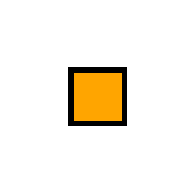

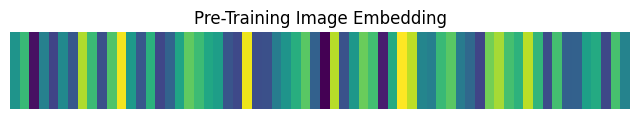

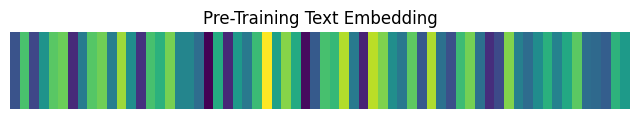

In [ ]:
# @title
img_enc.eval(); text_enc.eval()

with torch.no_grad():
  # select a random index
  random_idx = random.randrange(len(full_ds))
  sample_img, sample_toks, sample_cap = full_ds[random_idx]
  sample_img = sample_img.unsqueeze(0).to(device)
  sample_toks = sample_toks.unsqueeze(0).to(device)

  pre_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
  pre_train_txt_emb = text_enc(sample_toks).squeeze(0).cpu().numpy()

# Display the sample image and caption
print(f"Sample image and caption for embeddings visulization: {sample_cap}")
show_image(sample_img.squeeze(0).cpu())

# Function to visualize embeddings (simplified)
def plot_embedding(embedding, title):
  plt.figure(figsize=(8, 1))
  plt.imshow(embedding.reshape(1, -1), aspect='auto', cmap='viridis')
  plt.title(title)
  plt.axis('off')
  plt.show()

plot_embedding(pre_train_img_emb, "Pre-Training Image Embedding")
plot_embedding(pre_train_txt_emb, "Pre-Training Text Embedding")

In [ ]:
# @title
best_val = float('inf')

for epoch in range(1, EPOCHS+1):
  img_enc.train(); text_enc.train()
  total = 0.0
  for imgs, toks, _ in train_loader:
    imgs = imgs.to(device); toks = toks.to(device)
    optimizer.zero_grad(set_to_none=True)
    ie = img_enc(imgs); te = text_enc(toks)
    loss = clip_loss(ie, te)
    loss.backward()
    optimizer.step()
    total += loss.item()*imgs.size(0)

  train_loss = total / len(train_ds)

  # quick val
  img_enc.eval(); text_enc.eval()
  with torch.no_grad():
    vtotal, n = 0.0, 0
    for imgs, toks, _ in val_loader:
        imgs = imgs.to(device); toks = toks.to(device)
        vtotal += clip_loss(img_enc(imgs), text_enc(toks)).item() * imgs.size(0)
        n += imgs.size(0)
    val_loss = vtotal / n

  print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")
  best_val = min(best_val, val_loss)

Epoch 01 | train 2.5553 | val 2.4271
Epoch 02 | train 2.4088 | val 2.2894
Epoch 03 | train 1.9824 | val 1.3575
Epoch 04 | train 0.9664 | val 0.6300
Epoch 05 | train 0.5480 | val 0.4760
Epoch 06 | train 0.4450 | val 0.3816
Epoch 07 | train 0.3242 | val 0.2870
Epoch 08 | train 0.3091 | val 0.3901
Epoch 09 | train 0.2648 | val 0.2258
Epoch 10 | train 0.2250 | val 0.1251
Epoch 11 | train 0.1263 | val 0.1117
Epoch 12 | train 0.0799 | val 0.1058
Epoch 13 | train 0.1149 | val 0.1175
Epoch 14 | train 0.1090 | val 0.0928
Epoch 15 | train 0.1812 | val 0.2254
Epoch 16 | train 0.1480 | val 0.1278
Epoch 17 | train 0.1279 | val 0.1364
Epoch 18 | train 0.1227 | val 0.1214
Epoch 19 | train 0.0657 | val 0.1028
Epoch 20 | train 0.0945 | val 0.1095


Sample image and caption for embeddings visulization: orange square center


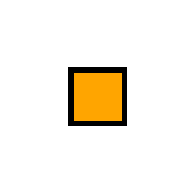

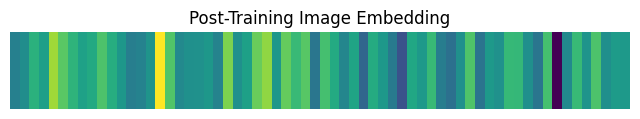

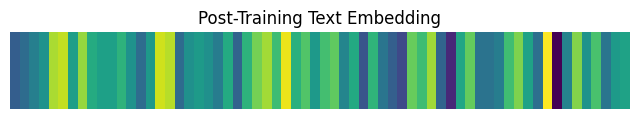

In [ ]:
# @title
img_enc.eval(); text_enc.eval()

with torch.no_grad():
  # select a random index
  sample_img, sample_toks, sample_cap = full_ds[random_idx]
  sample_img = sample_img.unsqueeze(0).to(device)
  sample_toks = sample_toks.unsqueeze(0).to(device)

  post_train_img_emb = img_enc(sample_img).squeeze(0).cpu().numpy()
  post_train_txt_emb = text_enc(sample_toks).squeeze(0).cpu().numpy()

# Display the sample image and caption
print(f"Sample image and caption for embeddings visulization: {sample_cap}")
show_image(sample_img.squeeze(0).cpu())

plot_embedding(post_train_img_emb, "Post-Training Image Embedding")
plot_embedding(post_train_txt_emb, "Post-Training Text Embedding")

In [ ]:
# Calculate and print dot products
print("\nDot product between image and text embeddings:")
print(f" Before training: {np.dot(pre_train_img_emb, pre_train_txt_emb):.4f}")
print(f" After training: {np.dot(post_train_img_emb, post_train_txt_emb):.4f}")


Dot product between image and text embeddings:
 Before training: -0.1728
 After training: 0.8421



Image 26 best captions:
  - yellow triangle top


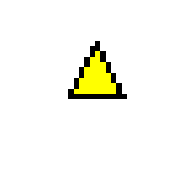


Text 'purple triangle center' best images:


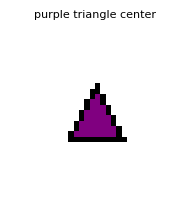

In [ ]:
# Retrieval helper functions

# First, compute embeddings for the validation set
img_enc.eval()
text_enc.eval()

val_imgs = []
val_caps = []
for img, toks, cap in val_ds:
    val_imgs.append(img)
    val_caps.append(cap)

val_imgs_tensor = torch.stack(val_imgs).to(device)
val_toks = torch.stack([full_ds.encode_text(cap) for cap in val_caps]).to(device)

with torch.no_grad():
    img_emb = img_enc(val_imgs_tensor)
    txt_emb = text_enc(val_toks)


def topk_text_for_images(k=3, idxs=None):
    """Given images, find the best matching text captions"""
    if idxs is None:
        idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (img_emb @ txt_emb.t()).softmax(dim=1)  # similarity as softmax
    for i in idxs:
        best = sims[i].topk(k).indices.tolist()
        print(f"\nImage {i} best captions:")
        for j in best:
            print("  -", val_caps[j])
        show_image(val_imgs[i].cpu())


def topk_images_for_text(k=3, idxs=None):
    """Given text captions, find the best matching images"""
    if idxs is None:
        idxs = np.random.choice(len(val_caps), size=1, replace=False)
    sims = (txt_emb @ img_emb.t()).softmax(dim=1)
    for i in idxs:
        best = sims[i].topk(k).indices.tolist()
        print(f"\nText '{val_caps[i]}' best images:")
        for j in best:
            show_image(val_imgs[j].cpu(), title=val_caps[j])


# Demo: show a few image-to-text and text-to-image retrievals
topk_text_for_images(k=1)
topk_images_for_text(k=1)